In [2]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from pathlib import Path
from torch import tensor,nn
import torch.nn.functional as F
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

path_data = Path('data')
path_gz = path_data/'mnist.pkl.gz'

MNIST_URL='https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=true'
path_data = Path('data')
path_data.mkdir(exist_ok=True)
path_gz = path_data/'mnist.pkl.gz'

from urllib.request import urlretrieve
if not path_gz.exists(): 
  urlretrieve(MNIST_URL, path_gz)

with gzip.open(path_gz, 'rb') as f: 
  ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

x_train, y_train, x_valid, y_valid = map(tensor, [x_train, y_train, x_valid, y_valid])

# Init setup 

## Data

In [3]:
row, col = x_train.shape
c = y_train.max() + 1
n_hidden = 50

In [5]:
print(row, col)

50000 784


In [4]:
class Model(nn.Module):
  def __init__(self, n_input, n_hidden, n_output):
    super().__init__()
    self.layers = [nn.Linear(n_input, n_hidden), nn.ReLU(), nn.Linear(n_hidden, n_output)]

  def __call__(self, x):
    for l in self.layers:
      x = l(x)
    return x

In [6]:
model = Model(col, n_hidden, 10)
pred = model(x_train)
pred.shape

torch.Size([50000, 10])

In [12]:
pred[0], pred[0].exp()

(tensor([-0.09, -0.21, -0.08,  0.10, -0.04,  0.08, -0.04, -0.03,  0.01,  0.06], grad_fn=<SelectBackward0>),
 tensor([0.91, 0.81, 0.92, 1.10, 0.97, 1.09, 0.96, 0.97, 1.01, 1.06], grad_fn=<ExpBackward0>))

In [19]:
print(pred[0].exp().shape)
print(pred[0].exp().sum(-1).shape)
print(pred[0].exp().sum(-1, keepdim=True).shape)

torch.Size([10])
torch.Size([])
torch.Size([1])


In [7]:
def log_softmax(x):
  return (x.exp() / (x.exp().sum(-1, keepdim=True))).log()

In [8]:
log_softmax(pred)

tensor([[-2.37, -2.49, -2.36,  ..., -2.31, -2.28, -2.22],
        [-2.37, -2.44, -2.44,  ..., -2.27, -2.26, -2.16],
        [-2.48, -2.33, -2.28,  ..., -2.30, -2.30, -2.27],
        ...,
        [-2.33, -2.52, -2.34,  ..., -2.31, -2.21, -2.16],
        [-2.38, -2.38, -2.33,  ..., -2.29, -2.26, -2.17],
        [-2.33, -2.55, -2.36,  ..., -2.29, -2.27, -2.16]], grad_fn=<LogBackward0>)

In [9]:
log_softmax(pred).shape

torch.Size([50000, 10])

In [20]:
def log_softmax(x):
  return x - x.exp().sum(-1, keepdim=True).log()

In [22]:
def logsumexp(x):
  m = x.max(-1)[0]
  return m + (x-m[:, None]).exp().sum(-1).log()

In [23]:
def log_softmax(x):
  return x - x.logsumexp(-1, keepdim=True)

In [28]:
test_close(logsumexp(pred), pred.logsumexp(-1))
sm_pred = log_softmax(pred)
print(sm_pred.shape)
sm_pred

torch.Size([50000, 10])


tensor([[-2.37, -2.49, -2.36,  ..., -2.31, -2.28, -2.22],
        [-2.37, -2.44, -2.44,  ..., -2.27, -2.26, -2.16],
        [-2.48, -2.33, -2.28,  ..., -2.30, -2.30, -2.27],
        ...,
        [-2.33, -2.52, -2.34,  ..., -2.31, -2.21, -2.16],
        [-2.38, -2.38, -2.33,  ..., -2.29, -2.26, -2.17],
        [-2.33, -2.55, -2.36,  ..., -2.29, -2.27, -2.16]], grad_fn=<SubBackward0>)

In [25]:
y_train[:3]

tensor([5, 0, 4])

In [26]:
sm_pred[0, 5], sm_pred[1, 0], sm_pred[2, 4]

(tensor(-2.20, grad_fn=<SelectBackward0>),
 tensor(-2.37, grad_fn=<SelectBackward0>),
 tensor(-2.36, grad_fn=<SelectBackward0>))

In [27]:
sm_pred[[0,1,2], y_train[:3]]

tensor([-2.20, -2.37, -2.36], grad_fn=<IndexBackward0>)

In [29]:
def nll(input, target): 
  return -input[range(target.shape[0]), target].mean()

In [30]:
loss = nll(sm_pred, y_train)
loss

tensor(2.30, grad_fn=<NegBackward0>)

In [31]:
test_close(F.nll_loss(F.log_softmax(pred, -1), y_train), loss, 1e-3)

In [32]:
test_close(F.cross_entropy(pred, y_train), loss, 1e-3)

# Basic training loop

basically the training loop repeats over the following steps:

- get the output of the model on a batch of inputs
- compare the output to the labels we have and compute a loss
- calculate the gradients of the loss wrt to every parameter of the model
- update said parameters with those gradients to make them a little bit better

In [33]:
loss_func = F.cross_entropy

In [35]:
bs = 64 # batch size

xb = x_train[0:bs] # a mini-batch from x
preds = model(xb)
preds[0], pred.shape

(tensor([-0.09, -0.21, -0.08,  0.10, -0.04,  0.08, -0.04, -0.03,  0.01,  0.06], grad_fn=<SelectBackward0>),
 torch.Size([50000, 10]))

In [38]:
yb = y_train[0:bs]
loss_func(preds, yb)

tensor(2.30, grad_fn=<NllLossBackward0>)

In [39]:
torch.argmax(preds, dim=1)

tensor([3, 9, 3, 8, 5, 9, 3, 9, 3, 9, 5, 3, 9, 9, 3, 9, 9, 5, 8, 7, 9, 5, 3, 8, 9, 5, 9, 5, 5, 9, 3, 5, 9, 7, 5, 7, 9, 9, 3, 9, 3, 5, 3, 8,
        3, 5, 9, 5, 9, 5, 3, 9, 3, 8, 9, 5, 9, 5, 9, 5, 8, 8, 9, 8])

In [40]:
def accuracy(out, yb):
  return (torch.argmax(out, dim=1)==yb).float().mean()

In [41]:
accuracy(preds, yb)

tensor(0.09)

In [42]:
lr = 0.5
epochs = 3

In [43]:
for epoch in range(epochs):
  for i in range(0, row, bs):
    s = slice(i, min(row, i+bs))
    xb, yb = x_train[s], y_train[s]
    preds = model(xb)
    loss = loss_func(preds, yb)
    loss.backward()
    if i == 0:
      print(loss.item(), accuracy(preds, yb).item())
    with torch.no_grad():
      for l in model.layers:
        if hasattr(l, 'weight'):
          l.weight -= l.weight.grad * lr
          l.bias -= l.bias.grad * lr
          l.weight.grad.zero_()
          l.bias.grad.zero_()

2.3036487102508545 0.09375
0.12374813109636307 0.96875
0.09232576191425323 0.96875


# Using parameters and optim

## Parameter

In [44]:
class Model(nn.Module):
  def __init__(self, n_input, n_hidden, n_output):
    super().__init__()
    self.l1 = nn.Linear(n_input, n_hidden)
    self.l2 = nn.Linear(n_hidden, n_output)
    self.relu = nn.ReLU()
  
  def __call__(self, x):
    return self.l2(self.relu(self.l1(x)))

In [45]:
model = Model(col, n_hidden, 10)

for name, l in model.named_children():
  print(f"{name}: {l}")

l1: Linear(in_features=784, out_features=50, bias=True)
l2: Linear(in_features=50, out_features=10, bias=True)
relu: ReLU()


In [46]:
model

Model(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
  (relu): ReLU()
)

In [47]:
model.l1

Linear(in_features=784, out_features=50, bias=True)

In [48]:
for p in model.parameters():
  print(p.shape)

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


In [53]:
def fit():
  for epoch in range(epochs):
      for i in range(0, row, bs):
          s = slice(i, min(row,i+bs))
          xb,yb = x_train[s],y_train[s]
          preds = model(xb)
          loss = loss_func(preds, yb)
          loss.backward()
          if i==0: print(loss.item(), accuracy(preds, yb).item())
          with torch.no_grad():
              for p in model.parameters(): p -= p.grad * lr
              model.zero_grad()



In [54]:
fit()

2.309434175491333 0.0625
0.2006874680519104 0.953125
0.18196912109851837 0.9375


In [59]:
class DummyModule():
  def __init__(self, n_input, n_hidden, n_output):
    self._modules = {}
    self.l1 = nn.Linear(n_input, n_hidden)
    self.l2 = nn.Linear(n_hidden, n_output)
  
  def __setattr__(self,k,v):
    if not k.startswith("_"): 
      self._modules[k] = v
    super().__setattr__(k,v)
  
  def __repr__(self):
    return f'{self._modules}'
  
  def parameters(self):
    for l in self._modules.values():
      # TODO: rewrite with 'yield from'
      for p in l.parameters():
        yield p

In [60]:
mdl = DummyModule(col, n_hidden, 10)
mdl

{'l1': Linear(in_features=784, out_features=50, bias=True), 'l2': Linear(in_features=50, out_features=10, bias=True)}

In [62]:
for p in mdl.parameters():
  print(p.shape)

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


# Registering modules

We can use the original `layers` approach, but we have to register the modules

In [63]:
layers = [nn.Linear(col, n_hidden), nn.ReLU(), nn.Linear(n_hidden, 10)]

In [64]:
class Model(nn.Module):
  def __init__(self, layers):
    super().__init__()
    self.layers = layers
    for i, l in enumerate(self.layers):
      self.add_module(f'layer_{i}', l)
    
  def __call__(self, x):
    for l in self.layers:
      x = l(x)
    return x

In [65]:
model = Model(layers)
model

Model(
  (layer_0): Linear(in_features=784, out_features=50, bias=True)
  (layer_1): ReLU()
  (layer_2): Linear(in_features=50, out_features=10, bias=True)
)

# nn.ModuleList

`nn.ModuleList` does this for us.

In [66]:
class SequentialModel(nn.Module):
  def __init__(self, layers):
    super().__init__()
    self.layers = nn.ModuleList(layers)
  
  def __call__(self, x):
    for l in self.layers:
      x = l(x)
    return x

In [67]:
model = SequentialModel(layers)
model

SequentialModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [68]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

2.2982895374298096 0.171875
0.13497968018054962 0.921875
0.13634943962097168 0.953125


(tensor(0.01, grad_fn=<NllLossBackward0>), tensor(1.))

# nn.Sequential

`nn.Sequential` is a convenient class which does the same as the above:

In [69]:
model = nn.Sequential(nn.Linear(col, n_hidden), nn.ReLU(), nn.Linear(n_hidden, 10))

In [70]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

2.3362321853637695 0.046875
0.1516467183828354 0.9375
0.1311080902814865 0.953125


(tensor(0.01, grad_fn=<NllLossBackward0>), tensor(1.))

In [71]:
model

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

# optim

In [72]:
class Optimizer():
  def __init__(self, params, lr=0.5):
    self.params = list(params)
    self.lr = lr
  
  def step(self):
    with torch.no_grad():
      for p in self.params:
        p -= p.grad * self.lr
    
  def zero_grad(self):
    for p in self.params:
      p.grad.data.zero_()

In [73]:
model = nn.Sequential(nn.Linear(col, n_hidden), nn.ReLU(), nn.Linear(n_hidden, 10))

In [74]:
opt = Optimizer(model.parameters())

In [76]:
for epoch in range(epochs):
    for i in range(0, row, bs):
        s = slice(i, min(row,i+bs))
        xb,yb = x_train[s],y_train[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        if i==0: print(loss.item(), accuracy(preds, yb).item())

        opt.step()
        opt.zero_grad()

2.298452615737915 0.203125
0.11175425350666046 0.953125
0.08529762923717499 0.96875


In [77]:
from torch import optim

In [80]:
def get_model():
    model = nn.Sequential(nn.Linear(col,n_hidden), nn.ReLU(), nn.Linear(n_hidden,10))
    return model, optim.SGD(model.parameters(), lr=lr)

In [81]:
model,opt = get_model()
loss_func(model(xb), yb)

tensor(2.31, grad_fn=<NllLossBackward0>)

In [82]:
for epoch in range(epochs):
    for i in range(0, row, bs):
        s = slice(i, min(row,i+bs))
        xb,yb = x_train[s],y_train[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        if i==0: print(loss.item(), accuracy(preds, yb).item())
        opt.step()
        opt.zero_grad()

2.3226308822631836 0.03125
0.12706120312213898 0.953125
0.0936841294169426 0.96875


# Dataset and DataLoader

## Dataset

It's clunky to iterate through minibatches of x and y value separately:

- xb = x_train[s]
- yb = y_train[s]

Instead, let's do these two steps together, by introducting a `Dataset` class:

- xb, yb = train_ds[s]

In [83]:
class Dataset():
  def __init__(self, x, y):
    self.x = x
    self.y = y
  
  def __len__(self):
    return len(self.x)
  
  def __getitem__(self, idx):
    return self.x[idx], self.y[idx]

In [84]:
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)
assert len(train_ds)==len(x_train)
assert len(valid_ds)==len(x_valid)

In [85]:
xb,yb = train_ds[0:5]
assert xb.shape==(5,28*28)
assert yb.shape==(5,)
xb,yb

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([5, 0, 4, 1, 9]))

In [86]:
model,opt = get_model()

In [88]:
for epoch in range(epochs):
    for i in range(0, row, bs):
        xb,yb = train_ds[i:min(row,i+bs)]
        pred = model(xb)
        loss = loss_func(pred, yb)
        if i==0: print(loss.item(), accuracy(pred, yb).item())

        loss.backward()
        opt.step()
        opt.zero_grad()

2.2801003456115723 0.15625
0.1063414067029953 0.96875
0.11654412746429443 0.96875


# DataLoader

In [89]:
class DataLoader():
  def __init__(self, ds, bs):
    self.ds = ds
    self.bs = bs
  
  def __iter__(self):
    for i in range(0, len(self.ds), self.bs):
      yield self.ds[i:i+self.bs]

In [90]:
train_dl = DataLoader(train_ds, bs)
valid_dl = DataLoader(valid_ds, bs)

In [91]:
xb,yb = next(iter(valid_dl))
xb.shape

torch.Size([64, 784])

In [92]:
yb

tensor([3, 8, 6, 9, 6, 4, 5, 3, 8, 4, 5, 2, 3, 8, 4, 8, 1, 5, 0, 5, 9, 7, 4, 1, 0, 3, 0, 6, 2, 9, 9, 4, 1, 3, 6, 8, 0, 7, 7, 6, 8, 9, 0, 3,
        8, 3, 7, 7, 8, 4, 4, 1, 2, 9, 8, 1, 1, 0, 6, 6, 5, 0, 1, 1])

tensor(3)

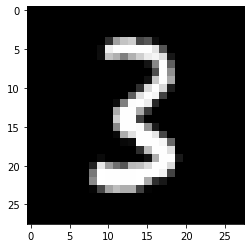

In [93]:
plt.imshow(xb[0].view(28,28))
yb[0]

In [94]:
model,opt = get_model()

In [95]:
def fit():
    for epoch in range(epochs):
        for xb,yb in train_dl:
            pred = model(xb)
            loss = loss_func(pred, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

In [96]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.04, grad_fn=<NllLossBackward0>), tensor(0.98))

# Random sampling

We want our training set to be in a random order, and that order should differ each iter. But the validation set shouldn't be randomized.

In [97]:
import random

class Sampler():
  def __init__(self, ds, shuffle=False):
    self.n = len(ds)
    self.shuffle = shuffle
  
  def __iter__(self):
    res = list(range(self.n))
    if self.shuffle:
      random.shuffle(res)
    return iter(res)

In [98]:
from itertools import islice

In [99]:
ss = Sampler(train_ds)

In [100]:
it = iter(ss)
for o in range(5):
  print(next(it))

0
1
2
3
4


In [101]:
list(islice(ss, 5))

[0, 1, 2, 3, 4]

In [102]:
ss = Sampler(train_ds, shuffle=True)
list(islice(ss, 5))

[32962, 26746, 6976, 43514, 25010]

In [104]:
import fastcore.all as fc

class BatchSampler():
    def __init__(self, sampler, bs, drop_last=False):
#         sampler,bs,drop_last = self.sampler,self.bs,self.drop_last
        fc.store_attr()

    def __iter__(self): 
      yield from fc.chunked(iter(self.sampler), self.bs, drop_last=self.drop_last)


In [105]:
batchs = BatchSampler(ss, 4)
list(islice(batchs, 5))

[[20114, 34218, 13883, 30709],
 [26656, 22381, 39596, 5985],
 [27552, 10810, 13873, 11094],
 [14918, 5254, 11945, 34848],
 [5479, 21926, 14030, 2166]]

In [106]:
def collate(b):
    xs,ys = zip(*b)
    return torch.stack(xs),torch.stack(ys)

In [107]:
class DataLoader():
    def __init__(self, ds, batchs, collate_fn=collate): 
      fc.store_attr()
      
    def __iter__(self): 
      yield from (self.collate_fn(self.ds[i] for i in b) for b in self.batchs)

In [108]:
train_samp = BatchSampler(Sampler(train_ds, shuffle=True ), bs)
valid_samp = BatchSampler(Sampler(valid_ds, shuffle=False), bs)

In [109]:
train_dl = DataLoader(train_ds, batchs=train_samp, collate_fn=collate)
valid_dl = DataLoader(valid_ds, batchs=valid_samp, collate_fn=collate)

tensor(3)

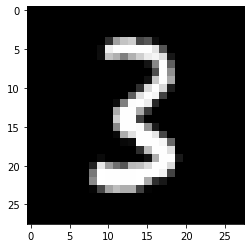

In [110]:
xb,yb = next(iter(valid_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

In [111]:
xb.shape,yb.shape

(torch.Size([64, 784]), torch.Size([64]))

In [112]:
model,opt = get_model()
fit()

loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.03, grad_fn=<NllLossBackward0>), tensor(1.))

# Multiprocessing DataLoader

In [113]:
import torch.multiprocessing as mp
from fastcore.basics import store_attr

In [114]:
train_ds[[3, 6, 8, 1]]

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([1, 1, 1, 0]))

In [115]:
x, y = train_ds[[3, 6, 8, 1]]
x.shape, y.shape

(torch.Size([4, 784]), torch.Size([4]))

In [116]:
train_ds.__getitem__([3, 6, 8, 1])

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([1, 1, 1, 0]))

In [117]:
for o in map(train_ds.__getitem__, ([3, 6], [8, 1])):
  print(o)

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([1, 1]))
(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([1, 0]))


In [120]:
class DataLoader:
  def __init__(self, ds, batchs, n_workers=1, collate_fn=collate):
    fc.store_attr()
  
  def __iter__(self):
    with mp.Pool(self.n_workers) as ex:
      yield from ex.map(self.ds.__getitem__, iter(self.batchs))

In [121]:
train_dl = DataLoader(train_ds, batchs=train_samp, collate_fn=collate, n_workers=2)
it = iter(train_dl)

In [122]:
xb,yb = next(it)
xb.shape,yb.shape

(torch.Size([64, 784]), torch.Size([64]))

In [123]:
# PyTorch DataLoader

In [124]:
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler, BatchSampler

In [125]:
train_samp = BatchSampler(RandomSampler(train_ds),     bs, drop_last=False)
valid_samp = BatchSampler(SequentialSampler(valid_ds), bs, drop_last=False)

In [126]:
train_dl = DataLoader(train_ds, batch_sampler=train_samp, collate_fn=collate)
valid_dl = DataLoader(valid_ds, batch_sampler=valid_samp, collate_fn=collate)

In [127]:
model,opt = get_model()
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.33, grad_fn=<NllLossBackward0>), tensor(0.91))

In [128]:
train_dl = DataLoader(train_ds, bs, sampler=RandomSampler(train_ds), collate_fn=collate)
valid_dl = DataLoader(valid_ds, bs, sampler=SequentialSampler(valid_ds), collate_fn=collate)

In [129]:
train_dl = DataLoader(train_ds, bs, shuffle=True, drop_last=True, num_workers=2)
valid_dl = DataLoader(valid_ds, bs, shuffle=False, num_workers=2)

In [130]:
model,opt = get_model()
fit()

loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.11, grad_fn=<NllLossBackward0>), tensor(0.95))

In [131]:
train_ds[[4,6,7]]

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([9, 1, 3]))

In [132]:
train_dl = DataLoader(train_ds, sampler=train_samp)
valid_dl = DataLoader(valid_ds, sampler=valid_samp)

In [133]:
xb,yb = next(iter(train_dl))
xb.shape,yb.shape

(torch.Size([1, 64, 784]), torch.Size([1, 64]))

# Validation

In [134]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb,yb in train_dl:
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

        model.eval()
        with torch.no_grad():
            tot_loss,tot_acc,count = 0.,0.,0
            for xb,yb in valid_dl:
                pred = model(xb)
                n = len(xb)
                count += n
                tot_loss += loss_func(pred, yb).item()*n
                tot_acc  += accuracy (pred,yb).item()*n
        print(epoch, tot_loss/count, tot_acc/count)
    return tot_loss/count, tot_acc/count


In [135]:
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
            DataLoader(valid_ds, batch_size=bs*2, **kwargs))

In [136]:
train_dl,valid_dl = get_dls(train_ds, valid_ds, bs)
model,opt = get_model()
loss,acc = fit(5, model, loss_func, opt, train_dl, valid_dl)

0 0.4051831236362457 0.8632
1 0.12521036615371703 0.9625
2 0.19334131327867507 0.9431
3 0.10655658054053783 0.9686
4 0.28995057399272917 0.9308
